In [1]:
# Some tools for writing this file:
line = '**********************************************************\n'
import numpy as np

# Code Generation:

My code supports following classes of CSS code:

    1.Rotated Surface Code
    2.(Quasi-cyclic) Hypergraph Product Code 
    3.Bivariate Bicycle Code
    

In [2]:
# examples of code construction
from code_construction.code_construction import CodeConstructor

# An example of rotated surface code
surface_code_constructor = CodeConstructor(method = 'rotated-surface')
distance3 = surface_code_constructor.construct(3)
print(f'{line}3x3 rotated surface code,n:{distance3.n},k:{distance3.k}\n{line}')
# this function take odd integers (p>=3) as input 
'''
 returns a CSSCode instance, which has:
 distance3.hx (np.ndarray),  # X stabilizers
 distance3.hz (np.ndarray),  # Z stabilizers
 distance3.n (int),          # number of data qubits
 distance3.k (int),          # number of logical qubits
 distance3.lx (np.ndarray),  # X logical operators
 distance3.lz (np.ndarray)   # Z logical operators
'''

# An example of hypergraph product code
hgp_code_constructor = CodeConstructor(method = 'qc-ldpc-hgp',para_dict = {
    'p':3,
    'q':3,
    'm':4
})
M = np.array([0,2,1,2,1,3,3,3,1]) # just a random (flatten) matrix in Z_5(m+1)^{3(p) \times 3(q)}, see the definition CodeConstructor.qc_ldpc_hgp_construction()
random_hgp_code = hgp_code_constructor.construct(M)
print(f'{line}A random hypergraph product code,n:{random_hgp_code.n},k:{random_hgp_code.k};\nThe weight of each row of Hx,Hz is upper bounded by 2*p = 6, the weight of each column of Hx,Hz is upper bounded by 2*q=6;\n n=m(p+q)\n{line}')

# An example of bivariate bicycle code
bb_code_constructor = CodeConstructor(method = 'bb',para_dict = {
    'l':12,
    'g':6
})
gross_parameter = [
    0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.
]
gross_code = bb_code_constructor.construct(gross_parameter)
print(f'{line}The [144,12,12] gross code,n:{gross_code.n},k:{gross_code.k}\n{line}')

**********************************************************
3x3 rotated surface code,n:9,k:1
**********************************************************

**********************************************************
A random hypergraph product code,n:288,k:8;
The weight of each row of Hx,Hz is upper bounded by 2*p = 6, the weight of each column of Hx,Hz is upper bounded by 2*q=6;
 n=m(p+q)
**********************************************************

**********************************************************
The [144,12,12] gross code,n:144,k:12
**********************************************************



# Estimation of logical error rate


### Depolarizing noise
Here we show the logical error rate under depolarizing noise, where:
$$
    \mathcal{E}(\rho) = (1-p)\rho + \frac{p}{3}(X\rho X + Y\rho Y + Z\rho Z),
$$
here $\rho$ is the density matrix of any single qubit in the data qubits. $p$ is the physical error rate. We can obtain the syndrome by:
$$
    s_x = H_z e_x, \quad s_z = H_x e_z,
$$
where $e_x,e_z\in \mathbb{Z}_2^{n}$ are binary vector representations of errors. e.g. $e_x = [1,0]^\top$ represents X error on the first qubit, and the second qubit does not have X error.

If we treat the decoder as a black box, which returns:
$$
    Decoder(s_x,s_z) = \hat{e}_x,\hat{e}_z.
$$
Then we check if $L_x(\hat{e}_x+e_x) = 0, L_z (\hat{e}_z+e_z)=0$. If this holds, that means the recovered error commutes with all the logical operators, which means the leftover is a stabilizer, the decoding is successful.

We estimate the logical error rate by Monte Carlo sampling errors and calculate the fail time.
$$
    LER = \frac{1}{N_{\text{shots}}} \sum_{i=1}^{N_{\text{shots}}} \delta_i,
$$
where:
$$
    \delta_i = \begin{cases}
        0, & \text{the $i$th sample's decoding is successful}\\
        1. & else
    \end{cases}
$$

Specifically, e_x,e_z are sampled according to what error does each i.i.d. qubit have.

Here we select `ldpc.bplsd_decoder.BpLsdDecoder`[[https://github.com/quantumgizmos/ldpc]] as our decoder.

In [3]:
# An example of calculating logical error rate:

from evaluation.decoder_based_evaluation import CSS_Evaluator
evaluator = CSS_Evaluator(gross_code.hx, gross_code.hz)
pL = evaluator.Get_logical_error_rate_Monte_Carlo(
    physical_error_rate=0.05,
    xyz_bias=[1, 1, 1],
    trail=10_000
)
print(f"gross code's logical error rate:{pL}, where physical error rate = 0.05")

gross code's logical error rate:0.0614, where physical error rate = 0.05


## Circuit-Level Noise

In circuit-level noise simulation, we explicitly construct the syndrome-measurement circuit of a given CSS code.  
Four types of physical error channels are added throughout the circuit:

1. **State Preparation Error (`pp`)**  
   Represents imperfect initialization of qubits.  
   Each qubit prepared in a computational basis state (typically $|0\rangle$ or $|+\rangle $) may be flipped with probability `pp`, corresponding to a depolarizing error applied immediately after state preparation.

2. **Measurement Error (`ps`)**  
   Models readout inaccuracy.  
   Each single-qubit measurement outcome may be flipped with probability `ps`, effectively simulating a bit-flip of the measurement result before it is recorded.

3. **Two-Qubit Gate Error (`pg`)**  
   Accounts for depolarizing noise following each entangling gate, such as a CNOT or CZ operation.  
   With probability `pg`, a random non-identity two-qubit Pauli operator (from the 15 possible $ \{IX, IY, IZ, XI, \ldots, ZZ\} $) is applied to the involved qubits, representing gate-induced decoherence or control infidelity.

4. **Single-Qubit Gate / Idle Error (`pd`)**  
   Models decoherence or depolarizing noise during idle periods and after single-qubit Clifford gates (e.g., Hadamard \(H\), Phase \(S\)).  
   Each qubit independently experiences a depolarizing channel with probability `pd`, representing memory decay or single-qubit control error.

We select parameters (namely, `pp`, `ps`, `pg`, `pd`) following the **SD6** model, where

$$
p_p = p_s = p_g = p_d = p.
$$

---

### Z-Memory Circuit

For the **Z-memory experiment**, the data qubits are initialized in the $|0\rangle^{\otimes n}$ state and the stabilizers are measured repeatedly over multiple rounds.  
The outcomes of each stabilizer measurement are compared between successive rounds to detect **changes in parity**, which define the **detectors**.

Formally, if $m_i^{(t)}$ denotes the measurement outcome of stabilizer $i$ in round $t$, then the corresponding detector bit is defined as

$$
d_i^{(t)} = m_i^{(t)} \oplus m_i^{(t-1)}.
$$

Each detector corresponds to a potential syndrome change caused by a physical error between the two rounds.

After running the circuit, the set of all detector outcomes $ \mathbf{d} \in \{0,1\}^N $ is passed to a decoder to infer a correction operator $\hat{E}$.

A decoding **success** occurs if the combined operator $(E \hat{E}$ acts trivially on all logical qubits, i.e.,

$$
(E \hat{E}) \in \mathcal{S},
$$
where \(\mathcal{S}\) is the stabilizer group.  
Otherwise, the event is counted as a **logical failure**.

---

### X-Memory Circuit

The **X-memory experiment** is defined similarly, except that data qubits are initialized in the $|+\rangle^{\otimes n}$ state and X-type stabilizers are measured.  
Logical failure is detected when the combined error and recovery flip the logical $X$-type observable.

---

### Estimating the Logical Error Rate

Let $p_Z$ and $p_X$ denote the estimated logical error rates from the Z- and X-memory experiments, respectively.  
Since both error types can occur independently, the total logical error rate is given by

$$
p_L = 1 - (1 - p_X)(1 - p_Z).
$$

---

### Implementation

We construct the syndrome-measurement circuits using [`stim.Circuit`](https://github.com/quantumlib/Stim) according to the structure of the code,  
and use [`sinter.Task`](https://github.com/trailofbits/sinter) to define and run the Monte Carlo decoding tasks.

For decoding, we employ the BP-LSD decoder  
implemented in [`ldpc.sinter_decoders.sinter_lsd_decoder.SinterLsdDecoder`](https://github.com/qecsim/ldpc),  
which performs iterative BP updates followed by low-weight search decoding to minimize the logical error probability.


In [4]:
from evaluation.circuit_level_noise import MonteCarloEstimationOfLogicalErrorRateUnderCircuitLevelNoise


mc = MonteCarloEstimationOfLogicalErrorRateUnderCircuitLevelNoise(gross_code,noise_model='SD6',p=0.007,rounds=12,custom_error_model={},decoder='bplsd')
pl = mc.run(shots= 100_000, max_error = 1000, num_workers = 24)
print(f'the logical error rate under SD6 noise model with physical error rate = 0.007 is :{pl}')

the logical error rate under SD6 noise model with physical error rate = 0.007 is :0.00025998559999995674


# Generating Datasets

Please see the sample bellow:

In [ ]:
from dataset import QEC_Dataset
l = 12
g = 6
dataset = QEC_Dataset(
                      l=l,
                      g=g,
                      oad = False,
                      number = 100,
                      save = True,
                      path='./data/codes',
                      p=0.007
                      noise_model='SD6',
                      noise_and_decoder_param={
                          'rounds':12,
                          'decoder':'bplsd',
                          'trail':100_000,
                          'max_error':100,
                          'num_worker':24
                      },
                      )
# this is used to generate the dataset; 
# you can selet l,g as you want(By this way you can only generate bb codes; if you want to generate other codes, please change the definition of QEC_Dataset in dataset.py)

Generating dataset...
code[1],logical error rate:0.1410254440052202
code[2],logical error rate:0.12649947299894604
code[3],logical error rate:0.967941400304414
code[4],logical error rate:0.15046149476972592
code[5],logical error rate:0.03673792385825858
code[6],logical error rate:0.12101078011411104
code[7],logical error rate:0.07121678973297008
code[8],logical error rate:0.06582500000000002
code[9],logical error rate:0.003034730748359138
code[10],logical error rate:0.005826727039220714
code[11],logical error rate:0.00536174430128844
code[12],logical error rate:0.9945774338569657
code[13],logical error rate:0.010879033027873297
code[14],logical error rate:0.8184577338129496
code[15],logical error rate:0.13408220850304398
code[16],logical error rate:0.279169366419165
code[17],logical error rate:0.9560808298631767
code[18],logical error rate:0.013755443560430236
code[19],logical error rate:0.7931416416857697
code[20],logical error rate:0.027447062080088624
code[21],logical error rate:0.0

loading
successfully loaded


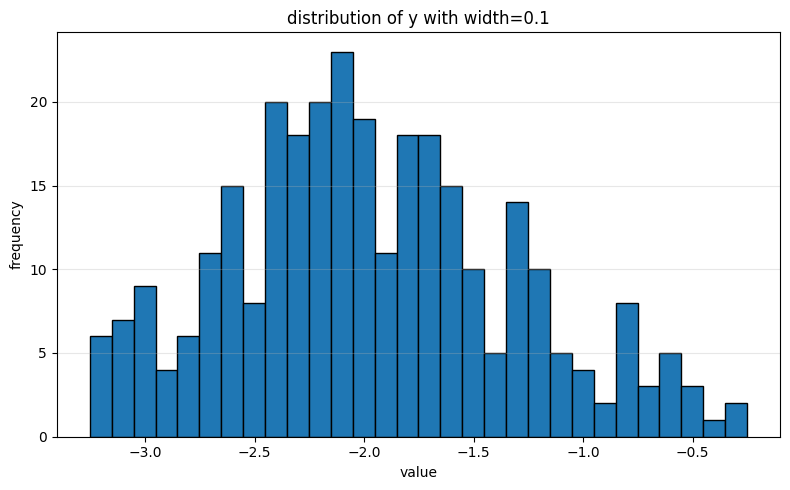

In [6]:
from sklearn.preprocessing import StandardScaler
import torch
from dataset import QEC_Dataset
import matplotlib.pyplot as plt
# delolarizing noise, physial error rate = 0.05
l = 6
g = 3
para_dict = {'l':l,'g':g}
total_dataset = QEC_Dataset(l,g,load = True,number = 300,save = True,path='./')
total_dataset.X = np.array(total_dataset.X)

# My current dataset uses word error rate: WER = 1-(1-LER)^{1/k}
def convert_to_logical_error_rate(x,y):
    codeconstructor = CodeConstructor(method='bb',para_dict = para_dict)
    x1 = codeconstructor.construct(x)
    # print(x.k)
    y =  1 - (1 - y)**x1.k
    return y
# set word error rate(logical error rate per qubit) to logical error rate
# print(total_dataset.y)
total_dataset.y = torch.tensor([convert_to_logical_error_rate(total_dataset.X[i],total_dataset.y[i]) for i in range(len(total_dataset.y))])
# print(total_dataset.y)



eps = 1e-8  
total_dataset.y = np.log(total_dataset.y + eps)

"""
    These 2 lines are used to normalize the y
"""
# sy = StandardScaler().fit(total_dataset.y.numpy().reshape(-1,1))
# total_dataset.y = torch.from_numpy(sy.transform(total_dataset.y.numpy().reshape(-1,1))).float()


import random
from torch.utils.data import Subset
import pandas as pd
def plot_distribution(y, bin_width):
    bins = np.arange(np.min(y), np.max(y) + bin_width, bin_width)
    
    plt.figure(figsize=(8, 5))
    plt.hist(y, bins=bins, edgecolor='black')
    plt.xlabel('value')
    plt.ylabel('frequency')
    plt.title(f'distribution of y with width={bin_width}')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_distribution(total_dataset.y.detach().cpu().numpy(), bin_width=0.1)

loading
successfully loaded
[tensor(0.0556), tensor(0.0578), tensor(0.0834), tensor(0.0991), tensor(0.1054), tensor(0.1148), tensor(0.1176), tensor(0.1217), tensor(0.1243), tensor(0.1262), tensor(0.1310), tensor(0.1346), tensor(0.1421), tensor(0.1456), tensor(0.1616), tensor(0.1640), tensor(0.1651), tensor(0.2039), tensor(0.2059), tensor(0.2192), tensor(0.2226), tensor(0.2229), tensor(0.2388), tensor(0.2408), tensor(0.2449), tensor(0.2535), tensor(0.2548), tensor(0.2606), tensor(0.2663), tensor(0.2769), tensor(0.2811), tensor(0.2828), tensor(0.2837), tensor(0.2918), tensor(0.2930), tensor(0.2951), tensor(0.2951), tensor(0.2953), tensor(0.2977), tensor(0.3002), tensor(0.3029), tensor(0.3087), tensor(0.3106), tensor(0.3148), tensor(0.3171), tensor(0.3178), tensor(0.3180), tensor(0.3202), tensor(0.3242), tensor(0.3358), tensor(0.3368), tensor(0.3631), tensor(0.3655), tensor(0.3673), tensor(0.3676), tensor(0.3866), tensor(0.3928), tensor(0.3947), tensor(0.3979), tensor(0.3984), tensor(0.39

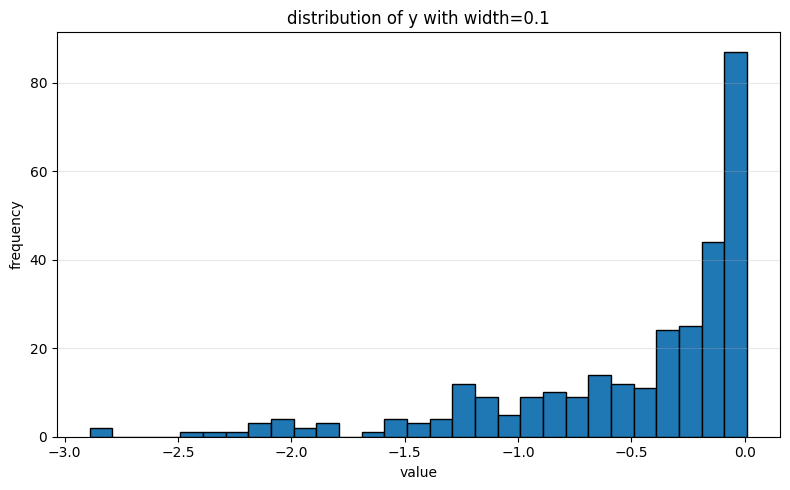

In [11]:
from sklearn.preprocessing import StandardScaler
import torch
from dataset import QEC_Dataset
import matplotlib.pyplot as plt
# SD6 noise, physical error rate = 0.007
l = 12
g = 6
para_dict = {'l':l,'g':g}
total_dataset = QEC_Dataset(l,g,load = True,number = 300,save = True,path='./')
total_dataset.X = np.array(total_dataset.X)

# My current dataset uses word error rate: WER = 1-(1-LER)^{1/k}
def convert_to_logical_error_rate(x,y):
    codeconstructor = CodeConstructor(method='bb',para_dict = para_dict)
    x1 = codeconstructor.construct(x)
    # print(x.k)
    y =  1 - (1 - y)**x1.k
    return y
# set word error rate(logical error rate per qubit) to logical error rate
# print(total_dataset.y)
total_dataset.y = torch.tensor([convert_to_logical_error_rate(total_dataset.X[i],total_dataset.y[i]) for i in range(len(total_dataset.y))])
# print(total_dataset.y)


print(sorted(total_dataset.y))
eps = 1e-8  
total_dataset.y = np.log(total_dataset.y + eps)

"""
    These 2 lines are used to normalize the y
"""
# sy = StandardScaler().fit(total_dataset.y.numpy().reshape(-1,1))
# total_dataset.y = torch.from_numpy(sy.transform(total_dataset.y.numpy().reshape(-1,1))).float()


import random
from torch.utils.data import Subset
import pandas as pd
def plot_distribution(y, bin_width):
    bins = np.arange(np.min(y), np.max(y) + bin_width, bin_width)
    
    plt.figure(figsize=(8, 5))
    plt.hist(y, bins=bins, edgecolor='black')
    plt.xlabel('value')
    plt.ylabel('frequency')
    plt.title(f'distribution of y with width={bin_width}')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    # plt.xscale('log')
    plt.show()
plot_distribution(total_dataset.y.detach().cpu().numpy(), bin_width=0.1)
